# Generic scikit-learn classifier

run any scikit-learn compatible classifier or list of classifiers

## Steps
1. **generate a scikit-learn model configuration** using the `model_pkg_class` parameter
   * input a package and class name, for example, `sklearn.linear_model.LogisticRegression`  
   * mlrun will find the class and instantiate a copy using default parameters  
   * You can modify both the model class instantiator and the fit methods  (other functions could be similarly modified)
2. **get a sample of data** from a data source
   * select all rows using -1
   * select a random sample of rows using a negative integer
   * select consecutive rows using a positive integer
3. **split the data** into train, validation, and test sets 
   * the test set is saved as an artifact and never seen again until testing
   * WIP: this will be parametrized to produce cross-validator splits (one way of performing CV)
4. **train the model** using xgboost in one of its flavours (dask, gpu, mpi...)
5. **pickle / serialize the model**
   * models can be pickled or saved as json (a newer xgboost format)
6. **evaluate the model**
   * a custom evaluator can be provided, see function doc for details

### Sklearn trainer setup

the following task paramaters are common to all runs

In [1]:
task_params = {
    # "name" : "sklearn classifier",
    "params": {
        "sample": -1,
        "test_size": 0.30,
        "train_val_split": 0.70,
        "random_state": 1,
        "n_jobs": -1,
        "plots_dest": "plots-p",
        "models_dest": "sklearn-clfmodel",
    }
}

models = [
    "sklearn.ensemble.RandomForestClassifier",
    "sklearn.linear_model.LogisticRegression",
    "sklearn.ensemble.AdaBoostClassifier",
]

### Set model parameters and run locally

* loop over a list of candidate models, update the task and run a local trainer for that model  
* optionally customize some parameters for each model
* accumulate the resulting artifacts in a list of dicts for debugging and testing purposes  

please note that the following parameters have been chosen without regard to optimization and model tuning

In [2]:
DATA_URL = "https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv"

> 2021-02-16 12:06:10,647 [info] starting run sklearn_ensemble_RandomForestClassifier uid=d4c414d723a64141a005709882f1fce3 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...82f1fce3,0,Feb 16 12:06:10,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=eyalskind=handlerowner=eyalshost=jupyter-eyals-666bf556fc-5v7bfclass=sklearn.ensemble.RandomForestClassifier,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelCLASS_max_depth=5,accuracy=0.90625test-error=0.09375auc-micro=0.99267578125auc-weighted=1.0f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run d4c414d723a64141a005709882f1fce3 --project default , !mlrun logs d4c414d723a64141a005709882f1fce3 --project default
> 2021-02-16 12:06:11,781 [info] run executed, status=completed
> 2021-02-16 12:06:11,782 [info] starting run sklearn_linear_model_LogisticRegression uid=4405c07ece36455a91f3d45b52ead7fb DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...52ead7fb,0,Feb 16 12:06:11,completed,sklearn_linear_model_LogisticRegression,v3io_user=eyalskind=handlerowner=eyalshost=jupyter-eyals-666bf556fc-5v7bfclass=sklearn.linear_model.LogisticRegression,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelCLASS_solver=liblinear,accuracy=0.875test-error=0.125auc-micro=0.97265625auc-weighted=0.997004357298475f1-score=0.8534798534798534precision_score=0.8518518518518517recall_score=0.9111111111111111,test_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 4405c07ece36455a91f3d45b52ead7fb --project default , !mlrun logs 4405c07ece36455a91f3d45b52ead7fb --project default
> 2021-02-16 12:06:12,448 [info] run executed, status=completed
> 2021-02-16 12:06:12,449 [info] starting run sklearn_ensemble_AdaBoostClassifier uid=b7fe7ac7a45747a58891e631633c3574 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...633c3574,0,Feb 16 12:06:12,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=eyalskind=handlerowner=eyalshost=jupyter-eyals-666bf556fc-5v7bfclass=sklearn.ensemble.AdaBoostClassifier,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelCLASS_n_estimators=200CLASS_learning_rate=0.01,accuracy=0.90625test-error=0.09375auc-micro=0.96044921875auc-weighted=1.0f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run b7fe7ac7a45747a58891e631633c3574 --project default , !mlrun logs b7fe7ac7a45747a58891e631633c3574 --project default
> 2021-02-16 12:06:13,607 [info] run executed, status=completed


<Figure size 432x288 with 0 Axes>

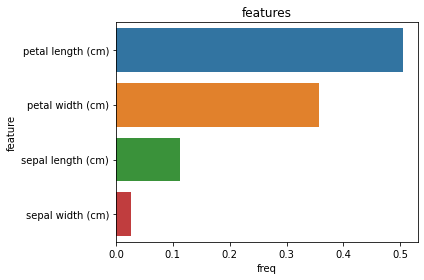

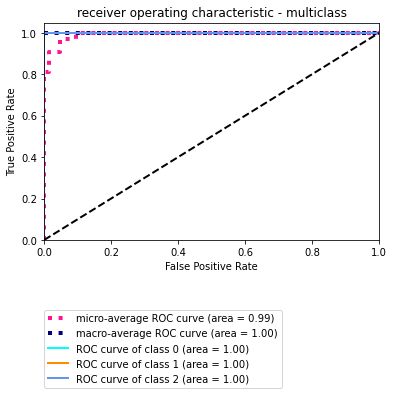

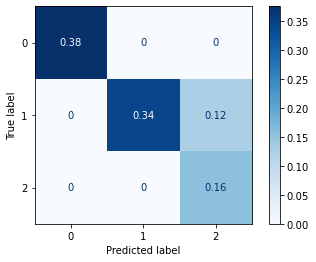

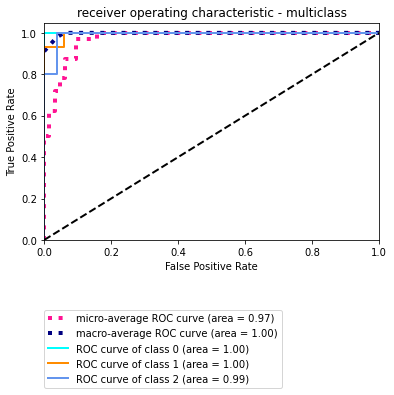

<Figure size 432x288 with 0 Axes>

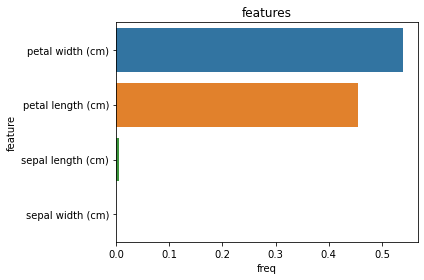

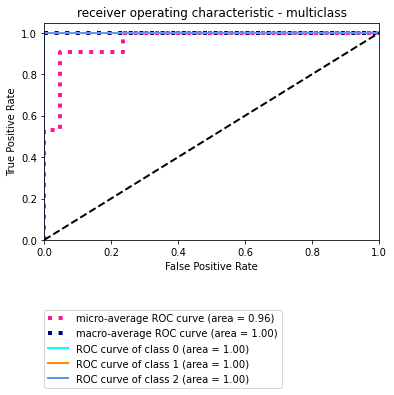

In [3]:
import os
import mlrun
from sklearn_classifier import train_model

_, artifact_path = mlrun.set_environment(
    api_path="http://mlrun-api:8080", artifact_path=os.path.abspath("./")
)

outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update({"params": {"model_pkg_class": model, "label_column": "label"}})

    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth": 5})

    if "LogisticRegression" in model:
        task_copy["params"].update({"CLASS_solver": "liblinear"})

    if "AdaBoostClassifier" in model:
        task_copy["params"].update(
            {"CLASS_n_estimators": 200, "CLASS_learning_rate": 0.01}
        )

    name = model.replace(".", "_")
    output = mlrun.run_local(
        mlrun.NewTask(**task_copy),
        handler=train_model,
        name=name,
        inputs={"dataset": DATA_URL},
        artifact_path=os.path.join(artifact_path, model),
    )

    outputs.append({name: output.outputs})

### Save

In [4]:
## Load Item
import yaml

with open("item.yaml") as item_file:
    items = yaml.load(item_file, Loader=yaml.FullLoader)

# create job function object from notebook code
fn = mlrun.code_to_function(
    items["name"],
    kind=items["spec"]["kind"],
    handler=items["spec"]["handler"],
    filename=items["spec"]["filename"],
    image=items["spec"]["image"],
    description=items["description"],
    categories=items["categories"],
    labels=items["labels"],
    requirements=items["spec"]["requirements"],
)

# add metadata (for templates and reuse)
fn.export("sklearn_classifier.yaml")

> 2021-02-16 12:06:14,397 [info] function spec saved to path: sklearn_classifier.yaml


### Examples - Run remotely

In [5]:
fn.apply(mlrun.platforms.auto_mount())

In [6]:
outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update({"params": {"model_pkg_class": model, "label_column": "label"}})

    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth": 5})

    if "LogisticRegression" in model:
        task_copy["params"].update({"CLASS_solver": "liblinear"})

    if "AdaBoostClassifier" in model:
        task_copy["params"].update(
            {"CLASS_n_estimators": 200, "CLASS_learning_rate": 0.01}
        )

    name = model.replace(".", "_")
    output = fn.run(
        mlrun.NewTask(**task_copy),
        handler=train_model,
        name=name,
        inputs={"dataset": DATA_URL},
        artifact_path=os.path.join(artifact_path, model),
    )

    outputs.append({name: output.outputs})

> 2021-02-16 12:06:14,428 [info] starting run sklearn_ensemble_RandomForestClassifier uid=0c24d8de2a0c43eba8e068e94c78a036 DB=http://mlrun-api:8080
> 2021-02-16 12:06:14,596 [info] Job is running in the background, pod: sklearn-ensemble-randomforestclassifier-zxq82
> 2021-02-16 12:06:20,283 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...4c78a036,0,Feb 16 12:06:19,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=eyalskind=jobowner=eyalshost=sklearn-ensemble-randomforestclassifier-zxq82class=sklearn.ensemble.RandomForestClassifier,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelCLASS_max_depth=5,accuracy=0.90625test-error=0.09375auc-micro=0.99365234375auc-weighted=0.997004357298475f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 0c24d8de2a0c43eba8e068e94c78a036 --project default , !mlrun logs 0c24d8de2a0c43eba8e068e94c78a036 --project default
> 2021-02-16 12:06:20,730 [info] run executed, status=completed
> 2021-02-16 12:06:20,732 [info] starting run sklearn_linear_model_LogisticRegression uid=f9d36fda7ba446da825add9e22cbcf72 DB=http://mlrun-api:8080
> 2021-02-16 12:06:20,886 [info] Job is running in the background, pod: sklearn-linear-model-logisticregression-htbk5
> 2021-02-16 12:06:25,963 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...22cbcf72,0,Feb 16 12:06:25,completed,sklearn_linear_model_LogisticRegression,v3io_user=eyalskind=jobowner=eyalshost=sklearn-linear-model-logisticregression-htbk5class=sklearn.linear_model.LogisticRegression,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelCLASS_solver=liblinear,accuracy=0.875test-error=0.125auc-micro=0.97265625auc-weighted=0.997004357298475f1-score=0.8534798534798534precision_score=0.8518518518518517recall_score=0.9111111111111111,test_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run f9d36fda7ba446da825add9e22cbcf72 --project default , !mlrun logs f9d36fda7ba446da825add9e22cbcf72 --project default
> 2021-02-16 12:06:27,007 [info] run executed, status=completed
> 2021-02-16 12:06:27,008 [info] starting run sklearn_ensemble_AdaBoostClassifier uid=d4b6b7df56a9411b9f10732292118a8b DB=http://mlrun-api:8080
> 2021-02-16 12:06:27,170 [info] Job is running in the background, pod: sklearn-ensemble-adaboostclassifier-prqqj
> 2021-02-16 12:06:33,244 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...92118a8b,0,Feb 16 12:06:31,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=eyalskind=jobowner=eyalshost=sklearn-ensemble-adaboostclassifier-prqqjclass=sklearn.ensemble.AdaBoostClassifier,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelCLASS_n_estimators=200CLASS_learning_rate=0.01,accuracy=0.90625test-error=0.09375auc-micro=0.96044921875auc-weighted=1.0f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run d4b6b7df56a9411b9f10732292118a8b --project default , !mlrun logs d4b6b7df56a9411b9f10732292118a8b --project default
> 2021-02-16 12:06:33,295 [info] run executed, status=completed
